## Introduction

[Nate Silver's article at FiveThirtyEight](https://fivethirtyeight.com/features/coronavirus-case-cou"nts-are-meaningless/?fbclid=IwAR1GPVJ4MPHXEZ8kSLYQKxY_DdVafvuCFwAylBC2bYxkhIwiKfnthZk34DU) claims that "*The number of reported COVID-19 cases is not a very useful indicator of anything unless you also know something about how tests are being conducted.*" 

The article includes a spreadsheet with which you can simulate how the spread of COVID-19 in a virtual country called Covidia would be observed and reported by conducting tests.  You can tweek various parameters very easily in the spreadsheet to see how they affect.  However, I found it's a bit difficult to make changes in the fundamental assumptions made in the spreadsheet.

So I made a Python program below that mimics the logic of Nate's spreadsheet so that I can give any changes not only in parameter values but also in any other assumptions.

At the bottom of this notebook, I tried to simulate the current situation in Japan.

## Parameters

There are 3 sets of parameters as follows.

### Disease_spread_parms

An instance of `Disease_spread_params` class holds disease spread related parameters as follows:

* `R_uncontrolled`: reproduction rate without any control;
* `R_intermediate`: reproduction rate with mild measures like social distancing, careful hand-washing and wearing masks;
* `R_lockdown`: reproduction rate under severe measure like lockdown;
* `cluster`: parameter that adjusts last-stage reproduction rate. (0=no adjust, 0.5: slightly, 1: moderately, 2: significantly);
* `begin_internmediate`: generation number when intermediate measures start;
* `begin_lockdown`: generation number when lockdown starts;
* `mild`: ratio of mild symptom; and
* `asymptomatic`: ratio of asymptomatic symptom (ratio of severe symptom is `1- mild- asymptomatic`.)

### Population_params

An instance of `Population_params` class holds population related parameters as follows:

* `population`: population of Covidia;
* `initial_infection`: initial infection in generation 0;
* `faux_severe`: proportion of population with severe symptoms for other reasons
* `faux_mild`: proportion of population with mild symptoms for other reasons;
* `desire_severe`: proportion of population with severe symptoms who want a test per generation;
* `desire_mild`: proportion of population with mild symptoms who want a test per generation; and
* `desire_asymptomatic`: propotion of population with no symptoms who want a test per generation

### Testing_params

An instance of `Testing_params` class holds testing related parameters as follows:

* `initial_tests`: initial number of tests in generation 1;
* `ramp_period`: generation where testing ramp-up begins;
* `test_growth_rate`: test growth rate per generation during ramp-up;
* `test_max`: maximum number of tests per generation (end of ramp-up);
* `rationed_test_ratio`: proportion of tests rationed to severe > mild > asymptomatic;
* `false_negative`: false negative rate;
* `false_positive`: false positive rate; and
* `delay`: reporting and testing delay in generation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time, re
import datetime

iround = lambda x: int((x * 2 + 1) // 2)

class Disease_spread_params:
    def __init__(self,
                 R_uncontrolled = 2.7,
                 R_intermediate = 1.4,
                 R_lockdown = 0.7,
                 cluster = 0.5,
                 begin_intermediate = 11,
                 begin_lockdown = 15,
                 mild = 0.6,
                 asymptomatic = 0.3,
                 zero_date = '2020-01-01',
                 serial = 5):
        self.R_uncontrolled = R_uncontrolled
        self.R_intermediate = R_intermediate
        self.R_lockdown = R_lockdown
        self.cluster = cluster
        self.begin_intermediate = begin_intermediate
        self.begin_lockdown = begin_lockdown
        self.severe = 1 - mild - asymptomatic
        self.mild = mild
        self.asymptomatic = asymptomatic
        self.zero_date = zero_date
        self.serial = serial

class Population_params:
    def __init__(self,
                 population = 10_000_000,
                 initial_infection = 1,
                 faux_severe = 0.001,
                 faux_mild = 0.025,
                 desire_severe = 1.0,
                 desire_mild = 0.5,
                 desire_asymptomatic = 0.02):
        self.population = population
        self.initial_infection = initial_infection
        self.faux_severe = faux_severe
        self.faux_mild = faux_mild
        self.desire_severe = desire_severe
        self.desire_mild = desire_mild
        self.desire_asymptomatic = desire_asymptomatic

class Testing_params:
    def __init__(self,
                 initial_tests = 1_000,
                 ramp_period = 3,
                 test_growth_rate = 0.5,
                 test_max = 10_000_000,
                 rationed_test_ratio = 0.75,
                 false_negative = 0.20,
                 false_positive = 0.002,
                 delay = 2):
        self.initial_tests = initial_tests
        self.ramp_period = ramp_period
        self.test_growth_rate = test_growth_rate
        self.test_max = test_max
        self.rationed_test_ratio = rationed_test_ratio
        self.false_negative = false_negative
        self.false_positive = false_positive
        self.delay = delay

## Simulator

Given parameters with the classes given aboves, `Simulator` class generates a `pandas.DataFrame` object that contains the simulation result.

The returned `DataFrame` has the following columns:

* `susceptible`: susceptible population (unobservable in practice);
* `new_infection`: number of actuall infected people (unobservable in practice);
* `cumulative_infection`: number of actually infected people (unobservable in practice);
* `actual_R`: actual reproduction rate (unobservable in practice);
* `actual_doubling_time`: doubling time of actual cumulative infection in days (unobservable in practice);
* `tests_available`: number of tests available;
* `new_detected_cases`: number of positive test cases;
* `cumulative_detected_cases`: cumulative number of positive test cases;
* `observed_R`: reproduction rate compted from tests;
* `observed_doubling_time`: positive test cases doubling time in days.

In [2]:
class Simulator:
    def __init__(self,
                 disease_spread_params,
                 population_params,
                 testing_params):
        self.disease_spread_params = disease_spread_params
        self.population_params = population_params
        self.testing_params = testing_params
        
        self.columns = [ 'date', 'actual.R', 'doubling time in days' ]
        self.date_regex = re.compile('(\d+)-(\d+)-(\d+)')

    def decode_date(self, date):
            match = self.date_regex.fullmatch(date)
            if match:
                y, m, d = match.group(1, 2, 3)
                timestamp = time.mktime((int(y), int(m), int(d), 0, 0, 0, -1, -1, -1))
                return timestamp
            return None
    
    def encode_date(self, timestamp):
        t = time.localtime(timestamp)
        return '{0:04d}-{1:02d}-{2:02d}'.format(t[0], t[1], t[2])

    def run(self, zero_day = '2020-01-01', generations = 40):
        self.generations = generations
        self.df = pd.DataFrame(index = range(0, self.generations))
        t0 = self.decode_date(zero_day)
        self.df['date'] = [ self.encode_date(t0 + d * self.disease_spread_params.serial * 24 * 60 * 60) for d in range(0, self.generations) ]

        self.set_target_R()
        self.compute_actual_infection()
        self.compute_tests()
        
        return self.df

    def set_target_R(self):
        begin_lockdown = self.disease_spread_params.begin_lockdown
        begin_intermediate = self.disease_spread_params.begin_intermediate
        self.df['target_R'] = np.NaN
        
        for i in range(0, self.generations):
            if begin_lockdown != None and i >= begin_lockdown:
                self.df.at[i, 'target_R'] = self.disease_spread_params.R_lockdown
            elif  begin_intermediate != None and i >= begin_intermediate:
                self.df.at[i, 'target_R'] = self.disease_spread_params.R_intermediate
            else:
                self.df.at[i, 'target_R'] = self.disease_spread_params.R_uncontrolled

    def compute_actual_infection(self):
        population = self.population_params.population
        initial_infection = self.population_params.initial_infection
        cluster = self.disease_spread_params.cluster
        serial = self.disease_spread_params.serial

        df = self.df
        df['susceptible'] = np.NaN
        df.at[0, 'susceptible'] = population - initial_infection
        df['new_infection'] = np.NaN
        df.at[0, 'new_infection'] = initial_infection
        df['cumulative_infection'] = np.NaN
        df.at[0, 'cumulative_infection'] = initial_infection
        df['actual_R'] = np.NaN
        df['actual_doubling_time'] = np.NaN
        
        for i in range(1, self.generations):
            df.at[i, 'new_infection'] = iround(df.at[i-1, 'susceptible']*(1-(1-((df.at[i-1, 'target_R']*(df.at[i-1, 'susceptible']/population)**cluster)/population))**df.at[i-1, 'new_infection']))
            df.at[i, 'cumulative_infection'] = df.at[i-1, 'cumulative_infection'] + df.at[i, 'new_infection']
            df.at[i, 'susceptible'] = population - df.at[i, 'cumulative_infection']
            df.at[i-1, 'actual_R'] = df.at[i, 'new_infection'] / df.at[i-1, 'new_infection']
            if df.at[i-1, 'cumulative_infection'] != 0:
                df.at[i-1, 'actual_doubling_time'] = np.inf if df.at[i, 'new_infection'] == 0 else serial * np.log(2) / np.log(df.at[i, 'cumulative_infection']/df.at[i-1, 'cumulative_infection'])

    def compute_tests(self):
        population = self.population_params.population
        ramp_period = self.testing_params.ramp_period
        tests_max = self.testing_params.test_max
        test_growth_rate = self.testing_params.test_growth_rate
        rationed_test_ratio = self.testing_params.rationed_test_ratio
        mild = self.disease_spread_params.mild
        asymptomatic = self.disease_spread_params.asymptomatic
        faux_severe = self.population_params.faux_severe
        faux_mild = self.population_params.faux_mild
        desire_severe = self.population_params.desire_severe
        desire_mild = self.population_params.desire_mild
        desire_asymptomatic = self.population_params.desire_asymptomatic
        false_negative = self.testing_params.false_negative
        false_positive = self.testing_params.false_positive
        delay = self.testing_params.delay
        serial = self.disease_spread_params.serial        

        cumulative_tests_conducted = 0
        cumulative_detected_cases = 0
        
        df = self.df
        df['tests_available'] = 0
        df['new_detected_cases'] = 0
        df['cumulative_detected_cases'] = 0
        
        for i in range(0, self.generations):
            if i  == 0:
                df.at[i, 'tests_available'] = 0
            elif i == 1:
                df.at[i, 'tests_available'] = self.testing_params.initial_tests
            elif i < ramp_period:
                df.at[i, 'tests_available'] = df.at[i-1, 'tests_available']
            else:
                df.at[i, 'tests_available'] = iround(min(tests_max, df.at[i-1, 'tests_available'] * (1 + test_growth_rate)))
            tests_available = df.at[i, 'tests_available']
            rationed_tests =  iround(tests_available * rationed_test_ratio)
            on_demand_tests = tests_available - rationed_tests

            new_infection_severe = iround(df.at[i, 'new_infection'] * (1 - mild - asymptomatic))
            new_infection_mild = iround(df.at[i, 'new_infection'] * mild)
            new_infection_asymptomatic = df.at[i, 'new_infection'] - new_infection_severe - new_infection_mild
            
            population_severe = iround((population - df.at[i, 'new_infection']) * faux_severe) + new_infection_severe
            population_mild = iround((population - df.at[i, 'new_infection']) * faux_mild) + new_infection_mild
            population_asymptomatic = population - population_severe - population_mild
            
            desiring_tests_severe = iround(population_severe * desire_severe * (1 - cumulative_tests_conducted/population))
            desiring_tests_mild = iround(population_mild * desire_mild * (1 - cumulative_tests_conducted/population))
            desiring_tests_asymptomatic = iround(population_asymptomatic * desire_asymptomatic * (1 - cumulative_tests_conducted/population))
            
            alloc_rationed_tests_severe = min(rationed_tests, desiring_tests_severe)
            alloc_rationed_tests_mild = min(desiring_tests_mild, rationed_tests-alloc_rationed_tests_severe)
            alloc_rationed_tests_asymptomatic = min(desiring_tests_asymptomatic, rationed_tests-alloc_rationed_tests_severe-alloc_rationed_tests_mild)

            unfilled_test_demand_severe = desiring_tests_severe - alloc_rationed_tests_severe
            unfilled_test_demand_mild = desiring_tests_mild - alloc_rationed_tests_mild
            unfilled_test_demand_asymptomatic = desiring_tests_asymptomatic - alloc_rationed_tests_asymptomatic
            unfilled_test_demand = unfilled_test_demand_severe + unfilled_test_demand_mild + unfilled_test_demand_asymptomatic
            
            alloc_on_demand_tests_severe = 0 if unfilled_test_demand == 0 else iround(on_demand_tests * unfilled_test_demand_severe / unfilled_test_demand)
            alloc_on_demand_tests_mild = 0 if unfilled_test_demand == 0 else iround(on_demand_tests * unfilled_test_demand_mild / unfilled_test_demand)
            alloc_on_demand_tests_asymptomatic = 0 if unfilled_test_demand == 0 else iround(on_demand_tests * unfilled_test_demand_asymptomatic / unfilled_test_demand)
            
            tests_conducted_severe = alloc_rationed_tests_severe + alloc_on_demand_tests_severe
            tests_conducted_mild = alloc_rationed_tests_mild + alloc_on_demand_tests_mild
            tests_conducted_asymptomatic = alloc_rationed_tests_asymptomatic + alloc_on_demand_tests_asymptomatic
            df.at[i, 'tests_conducted_severe'] = tests_conducted_severe
            df.at[i, 'tests_conducted_mild'] = tests_conducted_mild
            df.at[i, 'tests_conducted_asymptomatic'] = tests_conducted_asymptomatic
            tests_conducted = tests_conducted_severe + tests_conducted_mild + tests_conducted_asymptomatic
            
            cumulative_tests_conducted += tests_conducted
            
            positive_tests_severe = iround(tests_conducted_severe * new_infection_severe / population_severe * (1 - false_negative)) + \
              iround(tests_conducted_severe * (1 - new_infection_severe / population_severe) * false_positive)
            positive_tests_mild = iround(tests_conducted_mild * new_infection_mild / population_mild * (1 - false_negative)) + \
              iround(tests_conducted_mild * (1 - new_infection_mild / population_mild) * false_positive)
            positive_tests_asymptomatic = iround(tests_conducted_asymptomatic * new_infection_asymptomatic / population_asymptomatic * (1 - false_negative)) + \
              iround(tests_conducted_asymptomatic * (1 - new_infection_asymptomatic / population_asymptomatic) * false_positive)
            if i+delay < self.generations:
                df.at[i+delay, 'new_detected_cases'] = positive_tests_severe + positive_tests_mild + positive_tests_asymptomatic

            cumulative_detected_cases += df.at[i, 'new_detected_cases']
            df.at[i, 'cumulative_detected_cases'] = cumulative_detected_cases

            if i > 0 and df.at[i-1, 'new_detected_cases'] > 0:
                df.at[i-1, 'observed_R'] = df.at[i, 'new_detected_cases'] / df.at[i-1, 'new_detected_cases']
                df.at[i-1, 'observed_doubling_time'] = np.inf if df.at[i, 'new_detected_cases'] == 0 else serial * np.log(2) / np.log(df.at[i, 'cumulative_detected_cases']/df.at[i-1, 'cumulative_detected_cases'])

## Covidia Scenario 1: Robust testing

Testing capacity starts at 1,000 tests, but then increases by 50 percent per generation until all demand is met. Most tests (75%) are reserved for people with symptoms but some (25%) are available on-demand.

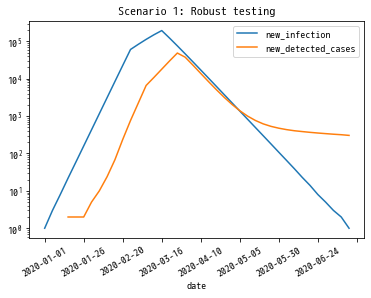

In [3]:
# all parameters are default for Scenario 1
disease_spread_params = Disease_spread_params()
population_params = Population_params()
testing_params = Testing_params()

# run
simulator = Simulator(disease_spread_params, population_params, testing_params)
df = simulator.run()

# plot
df = df.set_index('date').loc[:, ['new_infection', 'new_detected_cases']].replace(0, np.NaN)
df.plot(logy=True, title='Scenario 1: Robust testing', rot=30)

## Covidia Scenario 2: Sudden, one-time increase in testing

Testing capacity starts at 100 tests, which is very low, but then rapidly increases over a period of 4-5 weeks before maxing out at 100,000 tests. Most tests (75%) are reserved for people with symptoms but some (25%) are available on-demand.

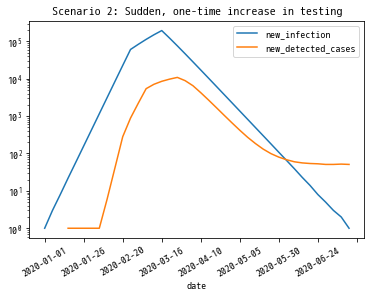

In [4]:
# parameter setting for Scenario 2
disease_spread_params = Disease_spread_params()
population_params = Population_params()
testing_params = Testing_params(
    initial_tests = 500,
    ramp_period = 6,
    test_growth_rate = 2,
    test_max = 25000,
)

# 実行
simulator = Simulator(disease_spread_params, population_params, testing_params)
df = simulator.run()

# plot
df = df.set_index('date').loc[:, ['new_infection', 'new_detected_cases']].replace(0, np.NaN)
df.plot(logy=True, title='Scenario 2: Sudden, one-time increase in testing', rot=30)

## Covidia Scenario 3: High test floor, low test ceiling

Testing capacity starts at 10,000 tests, but then increases by only 3 percent per generation before maxing out at 20,000 tests. All tests are rationed so people with more severe symptoms are given priority.

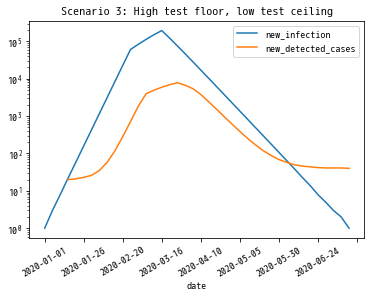

In [5]:
# parameter setting for Scenario 3
disease_spread_params = Disease_spread_params()
population_params = Population_params()
testing_params = Testing_params(
    initial_tests = 10000,
    ramp_period = 3,
    test_growth_rate = 0.03,
    test_max = 20000,
    rationed_test_ratio = 1.0
)

# 実行
simulator = Simulator(disease_spread_params, population_params, testing_params)
df = simulator.run()

# plot
df = df.set_index('date').loc[:, ['new_infection', 'new_detected_cases']].replace(0, np.NaN)
df.plot(logy=True, title='Scenario 3: High test floor, low test ceiling', rot=30)

## Covidia Scenario 4: A testing decrease

Testing capacity starts at 10,000 tests, but gradually decreases in the midst of the outbreak. The government also waits several additional weeks to declare a full lockdown. All tests are rationed so people with more severe symptoms are given priority.

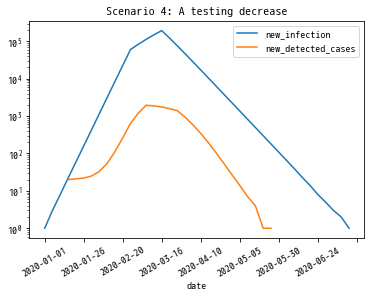

In [6]:
# parameter setting for Scenario 4
disease_spread_params = Disease_spread_params()
population_params = Population_params()
testing_params = Testing_params(
    initial_tests = 10000,
    ramp_period = 10,
    test_growth_rate = -0.2,
    test_max = 10000,
    rationed_test_ratio = 1.0
)

# run
simulator = Simulator(disease_spread_params, population_params, testing_params)
df = simulator.run()

# plot
df = df.set_index('date').loc[:, ['new_infection', 'new_detected_cases']].replace(0, np.NaN)
df.plot(logy=True, title='Scenario 4: A testing decrease', rot=30)

## Simulation for Japan

Japan has the following characteristics:

* Population is about 126,000,000
* Low test capacity: until March 4, test capacity was very low (a few hundreds per day). Since March 4, the capacity is said to be increased but actual numbers of conducted tests per day are around 1,000 [as reported by MHLW](https://www.mhlw.go.jp/content/10906000/000612050.pdf).
* Tests are highly rationed: without a doctor's strong request, no one can be tested
* Only mild measures have been implemented

,cumulative_infection,cumulative_detected_cases,real cumulative detected cases
date,,,
2019-12-25,1.0,NaN,NaN
2019-12-30,4.0,NaN,NaN
2020-01-04,12.0,NaN,NaN
2020-01-09,34.0,2.0,NaN
2020-01-14,93.0,4.0,NaN
2020-01-19,252.0,6.0,NaN
2020-01-24,681.0,8.0,NaN
2020-01-29,1839.0,10.0,4.8
2020-02-03,4965.0,12.0,17.2


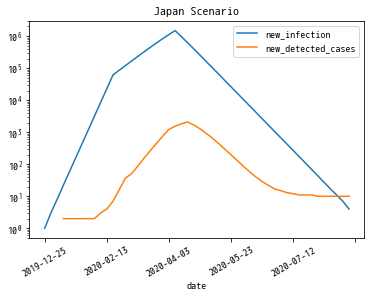

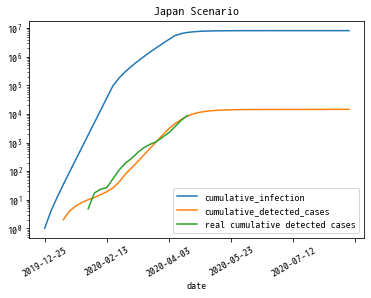

In [7]:
# parameters for Japan
disease_spread_params = Disease_spread_params(
    R_uncontrolled = 2.7, # no change as I have no plausible value
    R_intermediate = 1.4, # no change as I have no plausible value
    R_lockdown = 0.7, # higher than default as Japan's regulations are mild
    begin_intermediate = 11, #  people started to be careful around March 1
    begin_lockdown = 21, # emergency state declared on April 　7
)
population_params = Population_params(
    population = 126_000_000,  # Japan's population
    initial_infection = 1,
)
testing_params = Testing_params(
    initial_tests = 1000,  # initially only a few tests conducted (200 tests per day)
    ramp_period = 13,  # ramp up test capacity from March  6 
    test_growth_rate = 0.3,
    test_max = 5000, #  upto 1000 tests per day
    rationed_test_ratio = 0.95, # almost all the tests are rationed
)
zero_day = '2019-12-25'
generations = 50

# run
simulator = Simulator(disease_spread_params, population_params, testing_params)
df = simulator.run(zero_day=zero_day, generations=generations).set_index('date')
# display(df)

# plot
df1 = df.loc[:, ['new_infection', 'new_detected_cases']].replace(0, np.NaN)
df1.plot(logy=True, title='Japan Scenario', rot=30)

# compare with real data
date_regex = re.compile('(\d+)\/(\d+)\/(\d+)')
def convert_date(date):
    match = date_regex.fullmatch(date)
    if match:
        m, d, y = match.group(1, 2, 3)
        timestamp = time.mktime((int(y)+2000, int(m), int(d), 0, 0, 0, -1, -1, -1))
        t = time.localtime(timestamp)
        return '{0:04d}-{1:02d}-{2:02d}'.format(t[0], t[1], t[2])
    return None

csse_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
csse_df = pd.read_csv(csse_url)
csse_df = csse_df.drop(columns=["Lat", "Long"])
csse_df = csse_df.groupby("Country/Region").sum()
jp_df = csse_df.loc[['Japan'], :].T.rolling(5).mean()
jp_df['date']= [ convert_date(us_date) for us_date in jp_df.index ]
jp_df = jp_df.set_index('date')

df2 = df.loc[:, ['cumulative_infection', 'cumulative_detected_cases']].replace(0, np.NaN)
for date in df2.index:
    df2.at[date, 'real cumulative detected cases'] = jp_df.at[date, 'Japan'] if date in jp_df.index else np.NaN
df2.plot(logy=True, title='Japan Scenario', rot=30)

display(df2)